In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from scipy import io

import glmnet_python
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

from PIL import Image
from sklearn.model_selection import train_test_split,KFold
from pyglmnet import GLM, GLMCV, datasets, utils

import matplotlib
from mpl_toolkits import mplot3d
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):    
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); 
    s1 = 1/np.sum(input_array_1); 
    s2 = 1/np.sum(input_array_2);
    input_array_0 *= s0; 
    input_array_1 *= s1; 
    input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)   
                                     
    return input_array_mat

def posterior_array(freq_input, n_tones, p_back, p_low, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    prior_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
        
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 

    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, prior_tones_high, prior_tones_low, normalizer, posterior

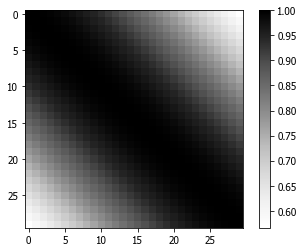

In [3]:
def design_prior_covariance(sigma_tonal=3.):
        '''Design a prior covariance matrix for STRF estimation.
        Args:
            sigma_temporal (float): Standard deviation of temporal prior
                covariance.
            sigma_spatial (float): Standard deviation of spatial prior
                covariance.
        Returns:
            numpy array: 2-d array of size :data:`(n_spatial_basis *
            n_temporal_basis, n_spatial_basis * n_temporal_basis)`, the
            ordering of rows and columns is so that all temporal basis are
            consecutive for each spatial basis.
        '''

        freq_seq = np.arange(90,3000,1) #array of possible true tones
        log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*40)
        n_features = len(log_freq_seq_array)
        
        tonal_covariance = np.zeros([n_features, n_features])
        prior_covariance = np.zeros([n_features, n_features])
        for i in np.arange(0, n_features):
            for j in np.arange(i, n_features):
                tonal_covariance[i, j] = np.exp(-1. / (sigma_tonal ** 2) *
                                             (log_freq_seq_array[i] - log_freq_seq_array[j]) ** 2)
                tonal_covariance[j, i] = tonal_covariance[i, j]

        prior_covariance = tonal_covariance
        prior_covariance = 1. / np.max(prior_covariance) * prior_covariance
        return prior_covariance
    

prior_cov = design_prior_covariance(sigma_tonal = 2)

plt.imshow(prior_cov, cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()    

In [11]:
""" 
Obtaining data from a given expt
"""
Test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials.csv')
Data = pd.read_csv('auditory_categorization_prolific_online_data/human_auditory_categorization_91686_2022-01-19_20h56.51_f8da6647-2fb7-444d-9e8c-e52b3a37d4b2/6139443561ab411be290efc1_categorization_task_2021-10-12_09h17.19.691.csv');

    

In [12]:
def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):   
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptCorrans, exptKeys
    

In [13]:
n_tones = 3

"""
Get tones and values of keys pressed from no context expt
"""
df_tones, df_corrans, df_keys = extractData(csv_test=Test, 
                                            csv_data=Data, 
                                            exptTotalLength=600, 
                                            exptLengthWithBreaks=603)    


In [14]:
def identifyResponseTrials(keysPressed, correctAns, tonesPlayed, exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
    print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
    
    return trialTonesResponded, trialBehaviourResponded, corransResponded

"""
Find no response cases in the no context expt
"""
trial_tones_expt, trial_behaviour_expt, corrans_expt = identifyResponseTrials(keysPressed = df_keys, 
                                                                            correctAns = df_corrans, 
                                                                            tonesPlayed = df_tones, 
                                                                            exptTotalLength = 600)

    

Did not respond to:  [ 46 219 390 485]
Got correct:  0.6466666666666666
No. of minority category correct:  0.717607973421927
Total trials played are 600, and total trials responded to are 596


In [15]:
expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

def betaValuesSim(tones_array,keys_num,
                  alpha,noTau, 
                  permutations):
    
    glmBetas = np.zeros((permutations,31))
    betas = np.zeros((permutations,31))
    GLMScoreTt = 0
    PyGLMScoreTt = 0
    
    kf = KFold(n_splits=permutations)
    nn = 0
    
    for train_index, test_index in kf.split(tones_array):
        # print("TEST:", test_index)
        Xtrain, Xtest = tones_array[train_index,:], tones_array[test_index,:]
        ytrain, ytest = keys_num[train_index], keys_num[test_index]
    
        """
        Train Variables
        """
        trial_tonesTr = np.repeat(Xtrain,1,axis = 0)
        trial_behaviourTr = np.reshape(ytrain,np.prod(ytrain.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTr = np.unique(tones_array)
        freqTableTr = np.zeros((len(trial_tonesTr),len(uniqueTonesTr)))
        for ii in range(len(trial_tonesTr)):
            for jj in trial_tonesTr[ii]:
                freqTableTr[ii,np.where(uniqueTonesTr==jj)] += 1        

        """
        Test Variables
        """
        trial_tonesTt = np.repeat(Xtest,1,axis = 0)
        trial_behaviourTt = np.reshape(ytest,np.prod(ytest.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTt = np.unique(tones_array)
        freqTableTt = np.zeros((len(trial_tonesTt),len(uniqueTonesTt)))
        for ii in range(len(trial_tonesTt)):
            for jj in trial_tonesTt[ii]:
                freqTableTt[ii,np.where(uniqueTonesTt==jj)] += 1       

        """
        Cross-validation using glmnet
        """
        #plt.figure()
        cvfit = cvglmnet(x = freqTableTr, y = trial_behaviourTr.astype(float),
                         family = 'binomial', ptype = 'class', alpha=alpha)
        """
        Results of fit
        """
        #cvglmnetPlot(cvfit)
        betas[nn] = cvglmnetCoef(cvfit, s='lambda_min').flatten()
        GLMScoreTt += sum(cvglmnetPredict(cvfit, newx=freqTableTt, s='lambda_min', ptype='class').flatten()
                          ==trial_behaviourTt)/len(trial_behaviourTt)

        """
        Cross-validation using pyglmnet
        """

        n_samples = freqTableTr.shape[0]
        """
        tau possibilities 
        """
        #Tau = utils.tikhonov_from_prior(prior_cov, n_samples)

        Tau = np.zeros((len(uniqueTonesTr),len(uniqueTonesTr)))
        for ii in range(len(uniqueTonesTr)):
            Tau[ii,ii] = 2
            if ii < len(uniqueTonesTr)-1:
                Tau[ii,ii+1] = -0.5-1
            if ii > 0:
                Tau[ii,ii-1] = -0.5

        # use the default value for reg_lambda
        glm = GLMCV(distr='binomial', alpha=alpha, Tau=(1-noTau)*Tau[1:-1,:], score_metric='accuracy',tol=1e-4,
                   max_iter=3000)
                
        # fit model
        glm.fit(freqTableTr, trial_behaviourTr.astype(float))

        # score the test set prediction
        #print("PyGLMNet train score: %f" % glm.score(freqTableTr, trial_behaviourTr))
        PyGLMScoreTt += glm.score(freqTableTt, trial_behaviourTt)

        glmBetas[nn,0] = glm.beta0_
        glmBetas[nn,1:] = glm.beta_
        
        nn+=1
    
    print(alpha, [GLMScoreTt/permutations, PyGLMScoreTt/permutations])
    
    return(uniqueTonesTr, betas, np.array(glmBetas), GLMScoreTt/permutations, PyGLMScoreTt/permutations)

In [ ]:
"""
Comparing both contexts for simulated behaviour
"""
GLMscore_no = np.zeros((11,1))
PyGLMscore_no = np.zeros((11,1))
GLMscore_v2_no = np.zeros((11,1))
PyGLMscore_v2_no = np.zeros((11,1))

for ialpha in range(0,11):
    [uniqueTonesSmall_v2, betasSmall_v2_no, pyGLMbetasSmall_v2_no,
    GLMscore_v2_no[ialpha], PyGLMscore_v2_no[ialpha]] = betaValuesSim(trial_tones_expt,
                                                                 trial_behaviour_expt,
                                                                 alpha = ialpha*0.1,
                                                                 noTau=0, 
                                                                 permutations=10)


In [16]:
"""
Plots that decide the correct alpha
"""
#plt.figure()
#plt.plot(range(0,11),PyGLMscore_v2_no, 'blue')

[uniqueTonesSmall_v2, betasSmall_v2_no, 
 pyGLMbetasSmall_v2_no,s1_no,s2_no] = betaValuesSim(trial_tones_expt,
                                                  trial_behaviour_expt,
                                                  alpha = 0,#np.argmax(PyGLMscore_v2_no )*0.1,
                                                  noTau=0, 
                                                  permutations=10)

0 [0.6908757062146893, 0.692457627118644]


glm scores for no context 0.6908757062146893 0.692457627118644
Norm of distractor weights compared to norm of all weights no context 0.6586750770159668
Bias terms no : 0.1103707458011846


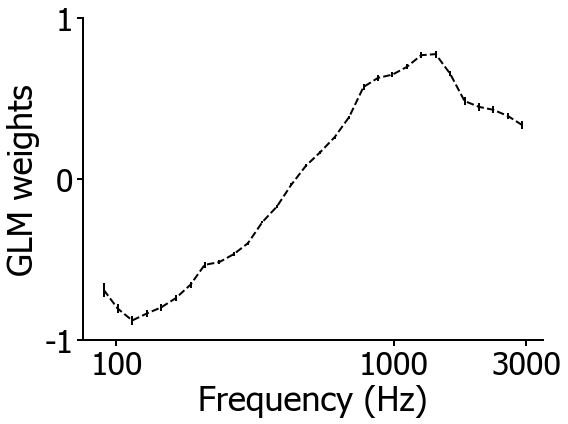

In [17]:
"""
Plots that check for smoothing due to tikhonov
"""
#print('alpha',(np.argmax(cumulativeScore))*0.1)
print('glm scores for no context',s1_no, s2_no)


fig, ax = plt.subplots(figsize=(8,6))
meanShift_no = np.mean(np.mean(pyGLMbetasSmall_v2_no[:,1:],axis=0))
glmWeights_no = np.mean(pyGLMbetasSmall_v2_no[:,1:],axis=0)-meanShift_no
plt.errorbar(np.log10(uniqueTonesSmall_v2),
             glmWeights_no, 
             np.std(pyGLMbetasSmall_v2_no[:,1:],axis=0)/np.sqrt(10), 
             color='black', ls='--',linewidth=2)
bias_no = np.mean(pyGLMbetasSmall_v2_no[:,0]) + 3*meanShift_no

print("Norm of distractor weights compared to norm of all weights no context",
      (sum(np.abs(glmWeights_no[:8]))+sum(np.abs(glmWeights_no[-8:])))/sum(np.abs(glmWeights_no)))

print(f"Bias terms no : {bias_no}")
ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels([100,1000,3000])
ax.set_yticks(ticks=np.array([1,0,-1]))
ax.set_yticklabels(np.array([1,0,-1]))
ax.tick_params(axis='both',labelsize=32,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=34)
ax.set_ylabel('GLM weights',fontsize=34)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.title(f'Pyglmnet elastic net with Tikhonov smoothing, alpha = {(np.argmax(cumulativeScore))*0.1}')
#pd.DataFrame(glmWeights_no).to_csv("figures/FromProlific/glms/glmsAcrossNoContext/5b34_noContext_GLMWeights.csv")
plt.savefig('figures/FromProlific/illustrations/experimenter=efc1_glm.pdf',
           bbox_inches='tight',transparent=True)
